In [85]:
import xgboost as xgb
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt #likley won't be used much as i'm experimenting with plotly 
import plotly.graph_objects as go #you will be learning how go and px work with me! 
import plotly.express as px 
import collections
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import math

In [2]:
#pip install seaborn

In [146]:
data = pd.read_csv("data.csv")
data

,weight,polnum,time,heating_system,num_bedroom,converted,randFact
0,1,x_mst_001,0,electric,4,0,0.606759
1,1,x_mst_002,0,electric,4,0,0.445243
2,1,x_mst_003,0,solid,2,1,0.114388
3,1,x_mst_004,0,solid,2,1,0.827792
4,1,x_mst_005,0,gas,3,1,0.366286
...,...,...,...,...,...,...,...
994,1,x_mst_995,2,solid,4,1,0.790298
995,1,x_mst_996,2,gas,5,0,0.630238
996,1,x_mst_997,2,gas,4,0,0.823006
997,1,x_mst_998,2,gas,3,1,0.326454


In [145]:
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x=data["heating_system"], y=data["num_bedrooms"], data=data)

In [157]:
# creating initial dataframe
dummy = pd.DataFrame(data["heating_system"], columns=['heating_system'])
# generate binary values using get_dummies
dum_df = pd.get_dummies(dummy, columns=["heating_system"], prefix=["heating_system"] )
# merge with main df bridge_df on key values
dummy = data.join(dum_df)
heating_df = dummy.drop(['heating_system', "polnum"], axis=1)
dummy

,weight,polnum,time,heating_system,num_bedroom,converted,randFact,heating_system_electric,heating_system_gas,heating_system_solid
0,1,x_mst_001,0,electric,4,0,0.606759,1,0,0
1,1,x_mst_002,0,electric,4,0,0.445243,1,0,0
2,1,x_mst_003,0,solid,2,1,0.114388,0,0,1
3,1,x_mst_004,0,solid,2,1,0.827792,0,0,1
4,1,x_mst_005,0,gas,3,1,0.366286,0,1,0
...,...,...,...,...,...,...,...,...,...,...
994,1,x_mst_995,2,solid,4,1,0.790298,0,0,1
995,1,x_mst_996,2,gas,5,0,0.630238,0,1,0
996,1,x_mst_997,2,gas,4,0,0.823006,0,1,0
997,1,x_mst_998,2,gas,3,1,0.326454,0,1,0


In [158]:
train = heating_df[heating_df["randFact"] < 0.9]
test = heating_df[heating_df["randFact"] >= 0.9]
train = train.drop(['randFact'], axis=1)
test = test.drop(['randFact'], axis=1)
train

,weight,time,num_bedroom,converted,heating_system_electric,heating_system_gas,heating_system_solid
0,1,0,4,0,1,0,0
1,1,0,4,0,1,0,0
2,1,0,2,1,0,0,1
3,1,0,2,1,0,0,1
4,1,0,3,1,0,1,0
...,...,...,...,...,...,...,...
994,1,2,4,1,0,0,1
995,1,2,5,0,0,1,0
996,1,2,4,0,0,1,0
997,1,2,3,1,0,1,0


In [159]:
dtrain = xgb.DMatrix(train.drop(['converted'], axis=1), label=train["converted"])
dtest = xgb.DMatrix(test.drop(['converted'], axis=1), label=train["converted"])
dtest

In [160]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
bst = xgb.train(param, dtrain, num_round)
#bst.save_model('0001.model')

# dump model
#bst.dump_model('dump.raw.txt')
# dump model with feature map
#bst.dump_model('dump.raw.txt', 'featmap.txt')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

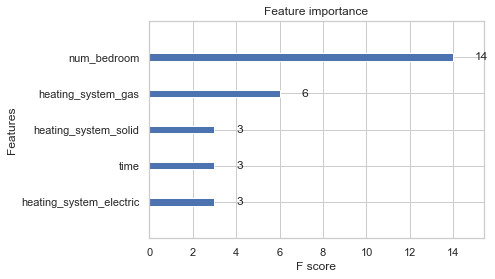

In [161]:
xgb.plot_importance(bst)

## GLM Fitting

In [162]:
factors_fitted = ["num_bedroom", "heating_system_electric"]
formula = 'converted ~ num_bedroom + heating_system_electric'
link_function = sm.families.links.logit
model_family = sm.families.Binomial(link = link_function)

<ipython-input-162-711937b1c170>:4: DeprecationWarning:

Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



In [163]:
model = glm(formula = formula, data = heating_df, family = model_family).fit()

In [164]:
print(model.summary())
#intercept is the Linear prdictor base value


                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                  999
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -497.24
Date:                Fri, 12 Mar 2021   Deviance:                       994.48
Time:                        09:30:34   Pearson chi2:                 1.00e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [165]:
output = dummy
output["predictions"]  = model.predict(dummy)
output

,weight,polnum,time,heating_system,num_bedroom,converted,randFact,heating_system_electric,heating_system_gas,heating_system_solid,predictions
0,1,x_mst_001,0,electric,4,0,0.606759,1,0,0,0.514992
1,1,x_mst_002,0,electric,4,0,0.445243,1,0,0,0.514992
2,1,x_mst_003,0,solid,2,1,0.114388,0,0,1,0.871753
3,1,x_mst_004,0,solid,2,1,0.827792,0,0,1,0.871753
4,1,x_mst_005,0,gas,3,1,0.366286,0,1,0,0.865171
...,...,...,...,...,...,...,...,...,...,...,...
994,1,x_mst_995,2,solid,4,1,0.790298,0,0,1,0.858307
995,1,x_mst_996,2,gas,5,0,0.630238,0,1,0,0.851153
996,1,x_mst_997,2,gas,4,0,0.823006,0,1,0,0.858307
997,1,x_mst_998,2,gas,3,1,0.326454,0,1,0,0.865171


In [150]:
#generalised
factor = "heating_sys_gas"



df = set(output[factor])
exposure =  dict.fromkeys(df, 0)
count = dict.fromkeys(df, 0)
conversion = dict.fromkeys(df, 0)
prediction = dict.fromkeys(df, 0)
exp_tot = output['weight'].sum()
multivar = dict.fromkeys(df, 0)


for i in df:
    exposure[i] = output.loc[output[factor] == i, 'weight'].sum()
    count[i] = output.loc[output[factor] == i, 'converted'].sum()
    conversion[i] = count[i]/exposure[i]
    prediction[i] = output.loc[output[factor] == i, 'predictions'].sum()/exposure[i]
    exposure[i] = exposure[i]/exp_tot
    
    if factor in factors_fitted:
        multivar[i] = math.exp(i*model.params[factor])/(1+(math.exp(i*model.params[factor])))
    else:
        multivar[i] = 0.5

In [130]:
#iteration 1

fig = go.Figure()
#fig.add_trace(go.Bar(x= list(exposure.keys()), y=list(exposure.values())))
#fig.add_trace(go.scatter(x= list(conversion.keys()), y=list(conversion.values())))

data = [
    go.Bar(
        x= list(exposure.keys()), 
        y= list(exposure.values()),
        yaxis='y1',
        marker_color='rgb(255, 230, 153)'
    ),
    go.Scatter(
        x= list(conversion.keys()),
        y= list(conversion.values()),
        yaxis='y2',
        marker_color='rgb(255, 73, 164)'
    ),
    go.Scatter(
        x= list(prediction.keys()),
        y= list(prediction.values()),
        yaxis='y2',
        marker_color='rgb(0, 102, 0)'
    ),
    go.Scatter(
        x= list(multivar.keys()),
        y= list(multivar.values()),
        yaxis='y2',
        marker_color='rgb(0, 255, 0)'
    )

]

layout = go.Layout(
    barmode='stack',
    title=factor,
    xaxis = dict(tickvals=list(exposure.keys())),
    yaxis=dict(title='exposure',
              range = [0,1]),
    yaxis2=dict(title='converson',
    overlaying='y',
    side='right',
    range = [0,1])
)

fig = go.Figure(data=data, layout=layout)
#fig.update_yaxes(range=[3, 9])
#fig.add_trace(secondary_y=True)
# IPython notebook
iplot(fig, filename='pandas-bar-chart-layout')

In [180]:
#generalised


def emblem_display (factor):

    df = set(output[factor])
    exposure =  dict.fromkeys(df, 0)
    count = dict.fromkeys(df, 0)
    conversion = dict.fromkeys(df, 0)
    prediction = dict.fromkeys(df, 0)
    exp_tot = output['weight'].sum()
    multivar = dict.fromkeys(df, 0)


    for i in df:
        exposure[i] = output.loc[output[factor] == i, 'weight'].sum()
        count[i] = output.loc[output[factor] == i, 'converted'].sum()
        conversion[i] = count[i]/exposure[i]
        prediction[i] = output.loc[output[factor] == i, 'predictions'].sum()/exposure[i]
        exposure[i] = exposure[i]/exp_tot

        if factor in factors_fitted:
            multivar[i] = math.exp(i*model.params[factor])/(1+(math.exp(i*model.params[factor])))
        elif str(factor + "_" + i) in factors_fitted:        
            multivar[i] = math.exp(model.params[factor + "_" + i])/(1+(math.exp(model.params[factor + "_" + i])))
        else:
            multivar[i] = 0.5
            
            
            
    fig = go.Figure()
    
      

    data = [
        go.Bar(
            x= list(exposure.keys()), 
            y= list(exposure.values()),
            yaxis='y1',
            marker_color='rgb(255, 230, 153)',
            name = "exposure"
        ),
        go.Scatter(
            x= list(conversion.keys()),
            y= list(conversion.values()),
            yaxis='y2',
            marker_color='rgb(255, 73, 164)',
            name = "conversion"
        ),
        go.Scatter(
            x= list(prediction.keys()),
            y= list(prediction.values()),
            yaxis='y2',
            marker_color='rgb(0, 102, 0)',
            name = "prediction"
        ),
        go.Scatter(
            x= list(multivar.keys()),
            y= list(multivar.values()),
            yaxis='y2',
            marker_color='rgb(0, 255, 0)',
            name = "multivar"
        )

    ]

    layout = go.Layout(
        barmode='stack',
        title=factor,
        xaxis = dict(tickvals=list(exposure.keys())),
        yaxis=dict(title='exposure',
                  range = [0,1]),
        yaxis2=dict(title='converson',
        overlaying='y',
        side='right',
        range = [0,1])
    )

    fig = go.Figure(data=data, layout=layout)
    #fig.update_yaxes(range=[3, 9])
    #fig.add_trace(secondary_y=True)
    # IPython notebook
    iplot(fig, filename='pandas-bar-chart-layout')

In [181]:
emblem_display("heating_system")

In [177]:
df = set(output["heating_system"])


multivar = dict.fromkeys(df, 0)


for i in df:
    
    #print(i)
    if str("heating_system" + "_" + i) in factors_fitted:
        print(str("heating_system" + "_" + i))
        
        multivar[i] = 0.5+math.exp(model.params["heating_system" + "_" + i])/(1+(math.exp(model.params["heating_system" + "_" + i])))
        
        print(multivar)
        

heating_system_electric
{'gas': 0, 'solid': 0, 'electric': 0.6491462085662846}


In [166]:
#iteration3





def emblem_display (factor):

    df = set(output[factor])
    exposure =  dict.fromkeys(df, 0)
    count = dict.fromkeys(df, 0)
    conversion = dict.fromkeys(df, 0)
    prediction = dict.fromkeys(df, 0)
    exp_tot = output['weight'].sum()
    multivar = dict.fromkeys(df, 0)


    for i in df:
        exposure[i] = output.loc[output[factor] == i, 'weight'].sum()
        count[i] = output.loc[output[factor] == i, 'converted'].sum()
        conversion[i] = count[i]/exposure[i]
        prediction[i] = output.loc[output[factor] == i, 'predictions'].sum()/exposure[i]
        exposure[i] = exposure[i]/exp_tot

        if factor in factors_fitted:
            multivar[i] = math.exp(i*model.params[factor])/(1+(math.exp(i*model.params[factor])))
        else:
            multivar[i] = 0.5
    fig = go.Figure()
    #fig.add_trace(go.Bar(x= list(exposure.keys()), y=list(exposure.values())))
    #fig.add_trace(go.scatter(x= list(conversion.keys()), y=list(conversion.values())))

    data = [
        go.Bar(
            x= list(exposure.keys()), 
            y= list(exposure.values()),
            yaxis='y1',
            marker_color='rgb(255, 230, 153)',
            name = "exposure"
        ),
        go.Scatter(
            x= list(conversion.keys()),
            y= list(conversion.values()),
            yaxis='y2',
            marker_color='rgb(255, 73, 164)',
            name = "conversion"
        ),
        go.Scatter(
            x= list(prediction.keys()),
            y= list(prediction.values()),
            yaxis='y2',
            marker_color='rgb(0, 102, 0)',
            name = "prediction"
        ),
        go.Scatter(
            x= list(multivar.keys()),
            y= list(multivar.values()),
            yaxis='y2',
            marker_color='rgb(0, 255, 0)',
            name = "multivar"
        )

    ]

    layout = go.Layout(
        barmode='stack',
        title=factor,
        xaxis = dict(tickvals=list(exposure.keys())),
        yaxis=dict(title='exposure',
                  range = [0,1]),
        yaxis2=dict(title='converson',
        overlaying='y',
        side='right',
        range = [0,1])
    )

    fig = go.Figure(data=data, layout=layout)
    #fig.update_yaxes(range=[3, 9])
    #fig.add_trace(secondary_y=True)
    # IPython notebook
    iplot(fig, filename='pandas-bar-chart-layout')

In [ ]:
name["time"] = {"levels":set(heating_df[i])}
name

In [ ]:
#iteration 2

fig = go.Figure()


buttons=[]

buttons.append(dict(method='restyle',
                    label='Data Scientist',
                    visible=True,
                    args=[{'y':[Roles['Data Scientist'].Q4.value_counts().values],
                           'x':[Roles['Data Scientist'].Q4.value_counts().index],
                           'type':'bar'}, [0]],
                    )
              )



data = [
    go.Bar(
        x= list(exposure.keys()), 
        y= list(exposure.values()),
        yaxis='y1'
    ),
    go.Scatter(
        x= list(conversion.keys()),
        y= list(conversion.values()),
        yaxis='y2'
    )]

layout = go.Layout(
    barmode='stack',
    title='num_bedroom',
    xaxis = dict(tickvals=list(exposure.keys())),
    yaxis=dict(title='exposure'),
    yaxis2=dict(title='converson',
    overlaying='y',
    side='right',
    range = [0,1])
)

fig = go.Figure(data=data, layout=layout)
#fig.update_yaxes(range=[3, 9])
#fig.add_trace(secondary_y=True)
# IPython notebook
iplot(fig, filename='pandas-bar-chart-layout')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x= edu.index, y=edu.values))

#buttons are the things you see in the dropdown 
buttons = []

#for each graph we want to show, we need a button for it
#you can do a lot with dropdowns, not just replace data 
buttons.append(dict(method='restyle',
                    label='2',
                    visible=True,
                    args=[{'y':[Roles[2].converted.value_counts().values],
                           'x':[Roles.keys()],
                           'type':'bar'}, [0]],
                    )
              )
buttons.append(dict(method='restyle',
                    label='3',
                    visible=True,
                    args=[{'y':[Roles[3].converted.value_counts().values],
                           'x':[Roles[3].converted.value_counts().index],
                           'type':'bar'}, [0]],
                    )
              )
buttons.append(dict(method='restyle',
                    label='4',
                    visible=True,
                    args=[{'y':[Roles[4].converted.value_counts().values],
                           'x':[Roles[4].converted.value_counts().index],
                           'type':'bar'}, [0]],
                    )
              )

#to get a menu to show, you need to create an updatemenu. 
#at this point I had no clue how it worked, I just was trying to get something to run

updatemenu = []
your_menu = {}
updatemenu.append(your_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

# add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=updatemenu)
fig.show()